<a href="https://colab.research.google.com/github/omdena/forestfire/blob/master/efficient_12layer_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Efficient 12-layer CNN**

This notebook is meant to implement a Convolutional Neural Network in Pytorch based on the one presented in https://www.researchgate.net/publication/329411277_An_Efficient_Deep_Learning_Algorithm_for_Fire_and_Smoke_Detection_with_Limited_Data for Smoke Detection

## **Environment setup**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install livelossplot
import os
import numpy as np
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
from pathlib import Path
from livelossplot import PlotLosses
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

forestfire_data_dir = Path('drive/My Drive/omdena-forestfire/data')
train_dataset_dir = forestfire_data_dir / 'smoky_images_train' / 'rand_dataset'
validation_dataset_dir = forestfire_data_dir / 'smoky_images_validation' / 'rand_dataset'
test_dataset_dir = forestfire_data_dir / 'smoky_images_test' / 'rand_dataset'

## **Data preparation**

The AmazonDataset is a subclass of the torch abstract class Dataset. The only requirements are to override the methods __len__ and __getitem__(ix).

In [0]:
class AmazonDataset(Dataset):
  def __init__(self, dataset_dir, transform=None, max_rows_per_class=6000, test=False, validation=False):
    self.transform = transform
    self.data = []

    for class_ in sorted(os.listdir(dataset_dir)):
      label = 0 if class_ == 'cleany' else 1   
      class_folder = os.path.join(dataset_dir, class_)
      class_folder_files = os.listdir(class_folder)
      
      if max_rows_per_class < len(class_folder_files):
        class_folder_files = random.sample(os.listdir(class_folder), max_rows_per_class)

      for ix, img_name in enumerate(class_folder_files):
        self.data.append([os.path.join(class_folder, img_name), label])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, ix):
    img = io.imread(self.data[ix][0])
    label = self.data[ix][1]

    if self.transform is not None:
      img = self.transform(img)

    return img, label

In [0]:
train_dataset = AmazonDataset(train_dataset_dir, transform=transforms.ToTensor())
validation_dataset = AmazonDataset(validation_dataset_dir, transform=transforms.ToTensor(), validation=True)
test_dataset = AmazonDataset(test_dataset_dir, transform=transforms.ToTensor(), test=True)

## **Building the model**

<figure>
<center>
<img src='https://drive.google.com/uc?id=1Bg_SoGAiTkm4DNKP6OlholWTJKBcytqh' />
<figcaption>NAMOZOV, A. & CHO, Y.. (2018). An Efficient Deep Learning Algorithm for Fire and Smoke Detection with Limited Data. Advances in Electrical and Computer Engineering. 18. 121-128. 10.4316/AECE.2018.04015. </figcaption></center>
</figure>

In [0]:
class Efficient12LayerCNN(nn.Module):
  def __init__(self):
    super(Efficient12LayerCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(128*16*16, 2048)
    self.fc2 = nn.Linear(2048, 2048)
    self.fc3 = nn.Linear(2048, 1)
    self.dropout = nn.Dropout(p=0.5)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))     # input is 3x128x128 -> output is 32x128x128
    x = F.relu(self.conv2(x))     # input is 32x128x128 -> output is 32x128x128
    x = self.pool(x)              # input is 32x128x128 -> output is 32x64x64
    x = F.relu(self.conv3(x))     # input is 32x64x64 -> output is 64x64x64
    x = F.relu(self.conv4(x))     # input is 64x64x64 -> output is 64x64x64
    x = self.pool(x)              # input is 64x64x64 -> output is 64x32x32
    x = F.relu(self.conv5(x))     # input is 64x32x32 -> output is 128x32x32
    x = F.relu(self.conv6(x))     # input is 128x32x32 -> output is 128x32x32
    x = self.pool(x)              # input is 128x32x32 -> output is 128x16x16
    x = x.view(-1, 128 * 16 * 16)
    x = self.dropout(self.fc1(x))
    x = self.dropout(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

## **Training the model**

In [0]:
class Model():
  def __init__(self, net, optimizer, loss):
    self.net = net
    self.optimizer = optimizer
    self.loss = loss
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.saved_eval_loss = []
  
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)

  def predict(self, imgs):
    self.net.to(self.device)
    self.net.eval()
    imgs = imgs.to(self.device)
    output = self.net(imgs).squeeze()
    probabilities = output.detach().cpu().numpy()
    predictions = (probabilities > 0.5).astype(int)
    return predictions, probabilities

  def fit(self, train_dataset, validation_dataset, epochs, batch_size=64):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

    liveloss = PlotLosses(skip_first=0)
    self.net.to(self.device)
    self.net.apply(Model.init_weights)
    
    for epoch in range(1, epochs+1):
      logs = {}
      # train
      self.net.train()
      train_loss, train_acc = [], 0
      for imgs, labels in tqdm(train_dataloader, desc="Training"):
        imgs, labels = imgs.to(self.device), labels.to(self.device)
        self.optimizer.zero_grad()
        output = self.net(imgs).squeeze()
        l = self.loss(output, labels.type(torch.float32))
        l.backward()
        self.optimizer.step()
        train_loss.append(l.item())
        train_acc += ((output > 0.5) == labels).sum().item()

      # eval
      self.net.eval()
      eval_loss, eval_acc = [], 0
      with torch.no_grad():
        for imgs, labels in tqdm(validation_dataloader, desc="Validation"):
          imgs, labels = imgs.to(self.device), labels.to(self.device)
          output = self.net(imgs).squeeze()
          l = self.loss(output, labels.type(torch.float32))
          eval_loss.append(l.item())
          eval_acc += ((output > 0.5) == labels).sum().item()
      
      self.saved_eval_loss.append(eval_loss)

      logs['log loss'] = np.mean(train_loss)
      logs['accuracy'] = train_acc / len(train_dataset)
      logs['val_log loss'] = np.mean(eval_loss)
      logs['val_accuracy'] = eval_acc / len(validation_dataset)

      print(f'Epoch: {epoch}/{epochs}\n Train loss: {np.mean(train_loss):.4f} Validation loss: {np.mean(eval_loss):.4f} Train Acc: {train_acc}/{len(train_dataset)} ({100*train_acc/len(train_dataset)} %) Validation Acc: {eval_acc}/{len(validation_dataset)} ({100*eval_acc/len(validation_dataset)} %)')

      liveloss.update(logs)
      liveloss.draw()

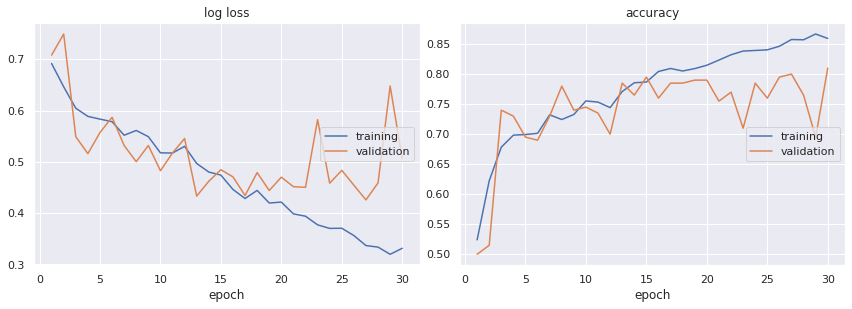

log loss:
training   (min:    0.320, max:    0.692, cur:    0.331)
validation (min:    0.426, max:    0.749, cur:    0.506)

accuracy:
training   (min:    0.524, max:    0.867, cur:    0.859)
validation (min:    0.500, max:    0.810, cur:    0.810)
CPU times: user 9min 47s, sys: 4min 22s, total: 14min 9s
Wall time: 17min 51s


In [91]:
%%time

net = Efficient12LayerCNN()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
loss = nn.BCELoss()
model = Model(net, optimizer, loss)

model.fit(train_dataset, validation_dataset, epochs=30)

## **Model evaluation**

Create a DataLoader for the unseen test set and predict the corresponding outputs with the trained model

In [0]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
test_imgs, test_labels = next(iter(test_dataloader))

y_pred, probabilities = model.predict(test_imgs)

y_true = test_labels.numpy()

In [93]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [94]:
y_pred

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [0]:
#probabilities

### **Confusion Matrix**

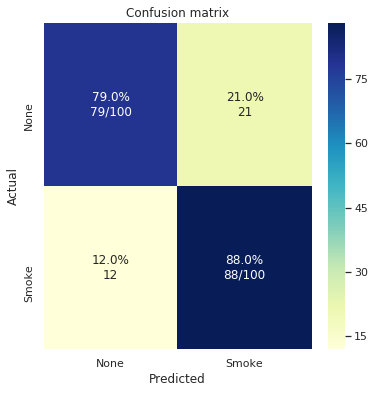

In [95]:
def plot_cm(y_true, y_pred, cm_columns, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=cm_columns, columns=cm_columns)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title('Confusion matrix')
    axs = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = axs.get_ylim()
    axs.set_ylim(bottom + 0.5, top - 0.5)

plot_cm(y_true, y_pred, ['None', 'Smoke'])

### **ROC Curve**

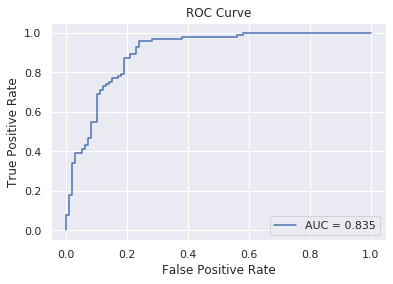

In [96]:
fpr, tpr, thresholds = roc_curve(y_true, probabilities)
auc = roc_auc_score(y_true, y_pred)

plt.plot(fpr, tpr, label='AUC = %.3f' % auc)
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### **Evaluation metrics**

In [97]:
print(f'Accuracy: {(accuracy_score(y_true, y_pred)*100):.1f}%')
print('Detection Rate (TPR/Recall): %.3f'%(recall_score(y_true, y_pred)))
print('False Alarm Rate (FPR): %.3f'%(1 - recall_score(y_true, y_pred, pos_label=0)))

Accuracy: 83.5%
Detection Rate (TPR/Recall): 0.880
False Alarm Rate (FPR): 0.210


## **Plot evaluation errors**

In [0]:
def get_string_label(label):
  return 'smoky' if label == 1 else 'cleany'

def plot_errors_sorted_by_loss(images, labels, probabilities, y_pred, y_true, loss):
  prediction_errors_indices = np.where(y_true != y_pred)[0]
  probabilities_t = torch.from_numpy(probabilities)

  indexes, predictions, actuals, losses = [], [], [], []
  for ix in prediction_errors_indices:
    pred_loss = loss(probabilities_t[ix], labels.type(torch.float32)[ix])
    prediction, actual = get_string_label(y_pred[ix]), get_string_label(y_true[ix])
    indexes.append(ix)
    predictions.append(prediction)
    actuals.append(actual)
    losses.append(pred_loss.item())
  df = pd.DataFrame({'ix': indexes, 'prediction': predictions, 'actual': actuals, 'loss': losses})
  df.sort_values('loss', inplace=True, ascending=False)
  df.reset_index(inplace=True)

  i = 0
  fig, axs = plt.subplots(5,5, figsize=(24,20))
  for _ax in axs:
    for ax in _ax:
      row = df.loc[i]
      img = test_imgs[row['ix']]
      ax.imshow(img.permute(1, 2, 0))
      ax.axis('off')
      ax.set_title(f'{row.prediction} / {row.actual} / {row.loss:.3f}')
      i += 1
  fig.suptitle(f'{df.shape[0]} errors / Prediction/Actual')
  plt.show()

**Validation**

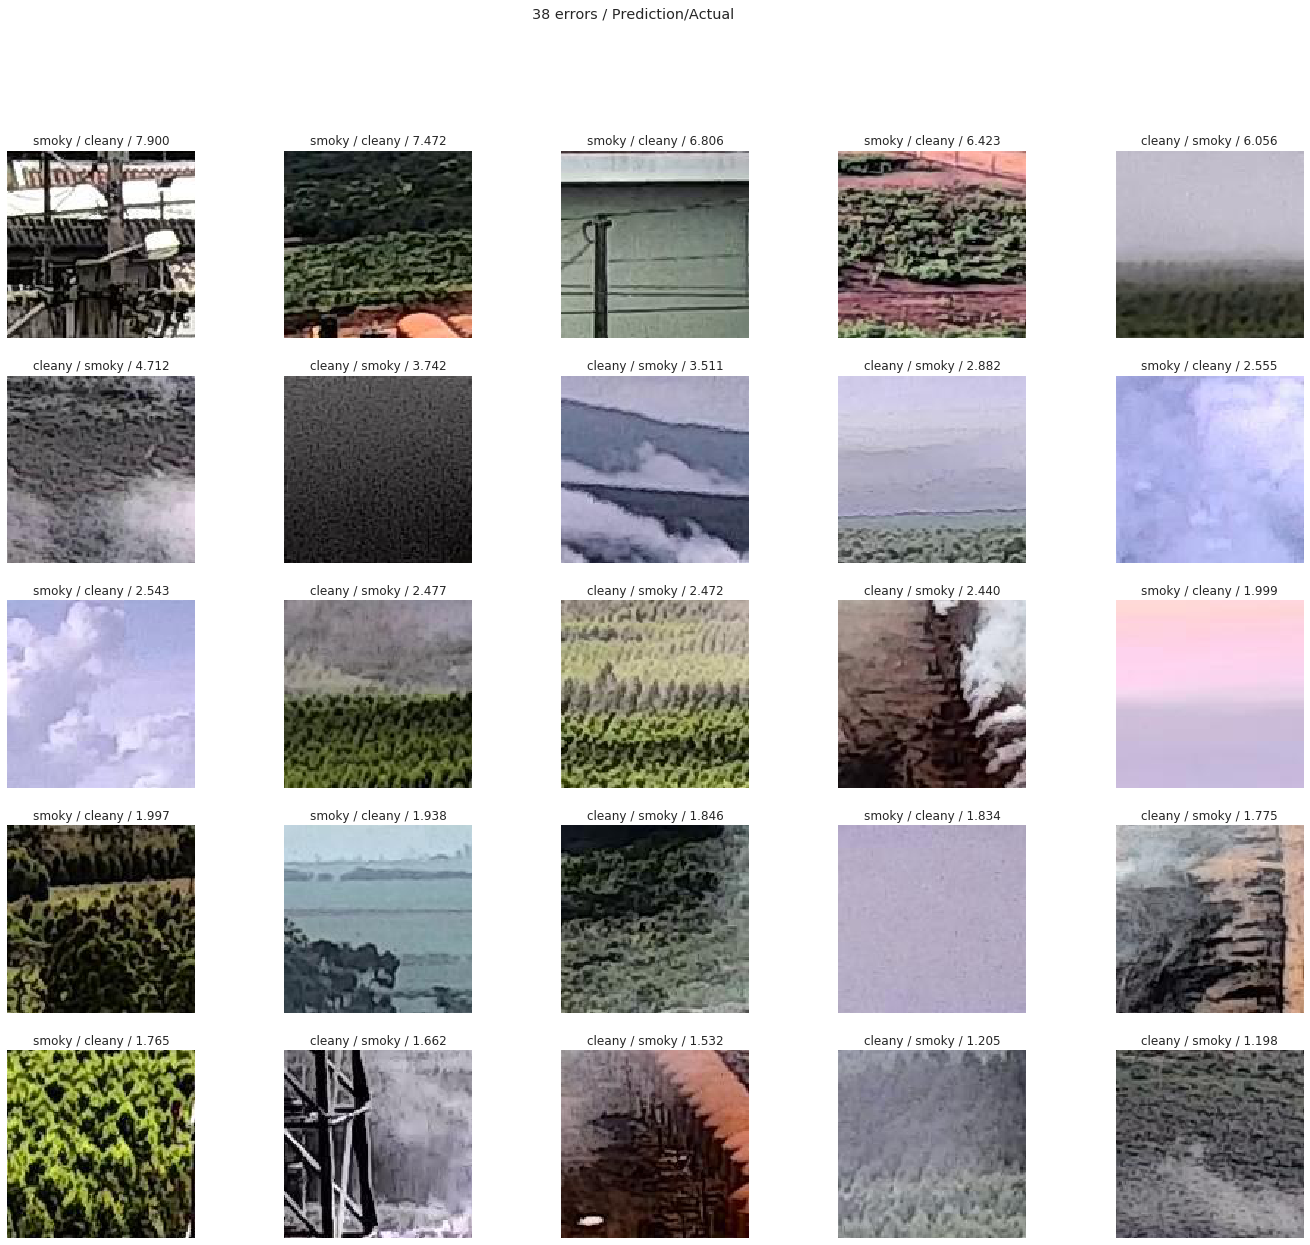

In [99]:
validation_eval_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset))
validation_eval_imgs, validation_eval_labels = next(iter(validation_eval_dataloader))

validation_eval_y_pred, validation_eval_probabilities = model.predict(validation_eval_imgs)

validation_eval_y_true = validation_eval_labels.numpy()

plot_errors_sorted_by_loss(validation_eval_imgs, validation_eval_labels, validation_eval_probabilities, validation_eval_y_pred, validation_eval_y_true, model.loss)

**Test**

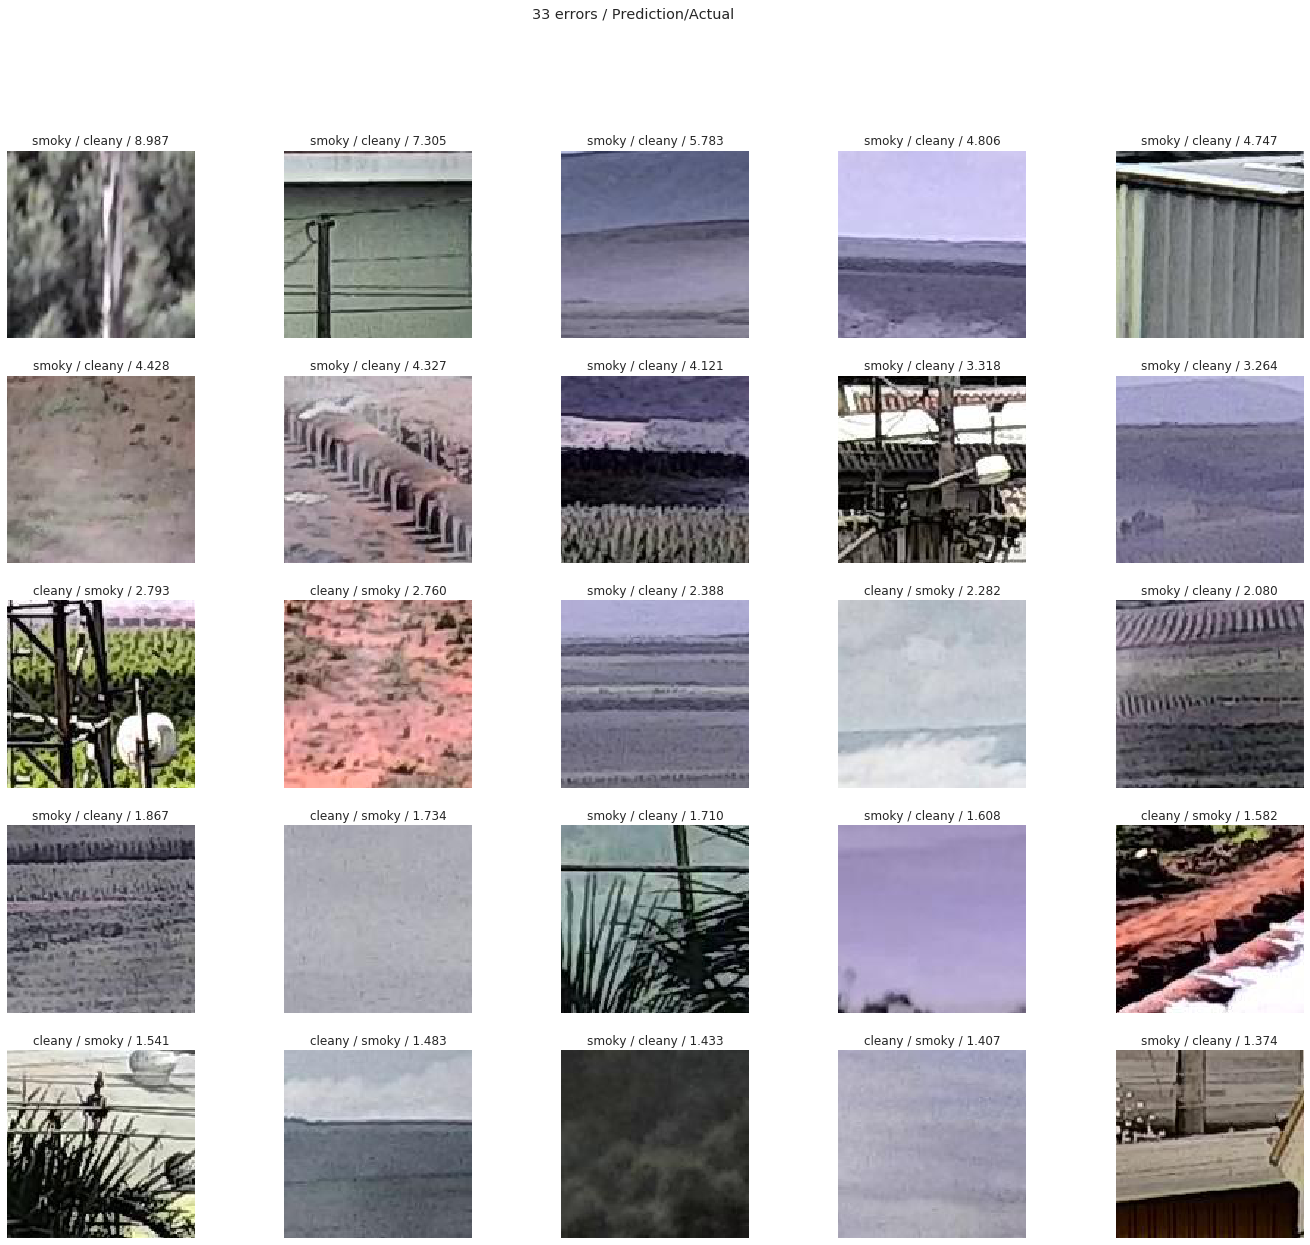

In [100]:
plot_errors_sorted_by_loss(test_imgs, test_labels, probabilities, y_pred, y_true, model.loss)

## **Save the model**

In [0]:
torch.save(model.net.state_dict(), 'efficient_12layer_cn.pt')

## **Load the model for inference**

In [0]:
loaded_net = Efficient12LayerCNN()
loaded_net.load_state_dict(torch.load('efficient_12layer_cn.pt'))

<All keys matched successfully>

In [0]:
test_dataloader = DataLoader(test_dataset, batch_size=64)
test_imgs, test_labels = next(iter(test_dataloader))

In [0]:
# If GPU available, uncomment lines below
#loaded_net.to('cuda:0')
#test_imgs = test_imgs.to('cuda:0')
loaded_net.eval()

Efficient12LayerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [0]:
output = loaded_net(test_imgs).squeeze()
probabilities = output.detach().cpu().numpy()
predictions = (probabilities > 0.5).astype(int)